In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression




In [3]:
df=pd.read_csv('spotify_millsongdata.csv')

In [4]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [5]:
df.shape

(57650, 4)

In [6]:
df=df.sample(20000).drop('link', axis=1).reset_index(drop=True)


In [7]:
pp=df.copy()

In [8]:
pp['text'] = pp['text'].apply(lambda x: str(x).lower().replace(r'^\w\s',' ').replace(r'\n',' ',))

In [9]:
df['text']= df['text'].apply(lambda x :str(x).replace(r'\n\r',' '))

NOW that we have assigned the link to another column we can drop them


In [10]:
df.shape

(20000, 3)

In [11]:
artist_list=df.groupby('artist').count()

Now we are having 643 artist list in our dataset


In [12]:
artist_list.count()

song    635
text    635
dtype: int64

In [13]:
df['song']=df['song'].str.lower()

In [14]:
df['text'].str.count('\n').sum()

822970

In [15]:
df.columns

Index(['artist', 'song', 'text'], dtype='object')

In [16]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string


In [17]:

# import nltk
# it is a nlp library , it is used to process the text data
# from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KUSHAL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In this the similar words which are having same meaning but differ in spelling are changed into one common word


In [18]:
def preprocess_text(text):
    tokens = word_tokenize(text)  # Tokenization and lowercase conversion
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]  # Stopword and punctuation removal
    
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)
     

In [19]:
# # import nltk
# # nltk.download('punkt')
# token(df['text'][0])
# token('hello world beautiful beauty')

In [20]:
df['cleaned text']=df['text'].apply(preprocess_text)


In [21]:
df.__len__()

20000

In [22]:

from sklearn.datasets import make_blobs
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

Here we are taking sample data for testing 


In [23]:
# Randomly sample a subset of song descriptions for clustering (adjust sample size as needed)
sample_size = 1000
random_indices = np.random.choice(len(df['cleaned text']), size=sample_size, replace=False)
sampled_descriptions = [df.iloc[i] for i in random_indices]

In [24]:
sampled_descriptions=pd.DataFrame(sampled_descriptions)

In [25]:
sampled_descriptions

,artist,song,text,cleaned text
1912,Leonard Cohen,field commander cohen,"Field Commander Cohen, he was our most importa...",Field Commander Cohen important spy Wounded li...
18233,Pearl Jam,i got you,"I got you, and that's all I want \r\nI won't ...",I got 's I want I wo n't forget 'cause 's whol...
17746,HIM,circle of fear,Heartache is knocking on her door \r\nShadows...,Heartache knocking door Shadows dance outside ...
1050,Whitney Houston,all the man that i need,I used to cry myself to sleep at night \r\nBu...,I used cry sleep night But came I thought love...
5368,King Diamond,mother's getting weaker,Tonight would be the last night that we had ou...,Tonight would last night tea That bloody tea s...
...,...,...,...,...
15445,John Denver,i remember you,I remember you \r\nYou're the one that made m...,I remember You 're one made dream come true Ju...
1070,Status Quo,dear john,Everybody was talking to me \r\nLike I was a ...,Everybody talking Like I child In word I could...
974,Andy Williams,tonight,If I could hold you in the arms of love tonigh...,If I could hold arm love tonight I 'd never le...
8863,Yngwie Malmsteen,facing the animal,Sinking my teeth \r\ninto you \r\nSweet obsc...,Sinking teeth Sweet obscenity You 're deep goo...


we need to change it to data frame

now that we got the sampled data , we gonna do tfidf on that sampled data


In [26]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
tdif=TfidfVectorizer(analyzer='word', stop_words='english')

In [27]:
matrix=tdif.fit_transform(sampled_descriptions['cleaned text'])

In [28]:
print(matrix.shape)

(1000, 8907)


In [29]:
wcss = []
silhouette_scores = []

# Try different values of k (number of clusters) and compute WCSS and silhouette scores
for k in range(2, 10):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
    kmeans.fit(matrix)
    wcss.append(kmeans.inertia_)  # Within-cluster sum of squares
    silhouette_scores.append(silhouette_score(matrix, kmeans.labels_))

C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The defaul

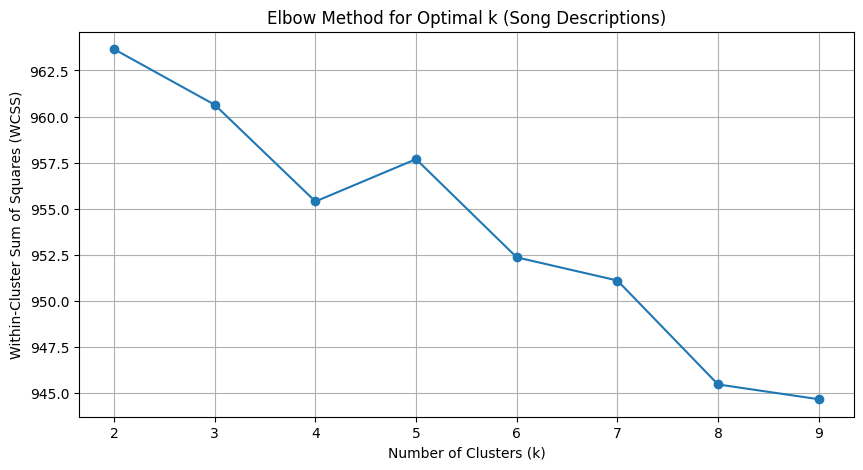

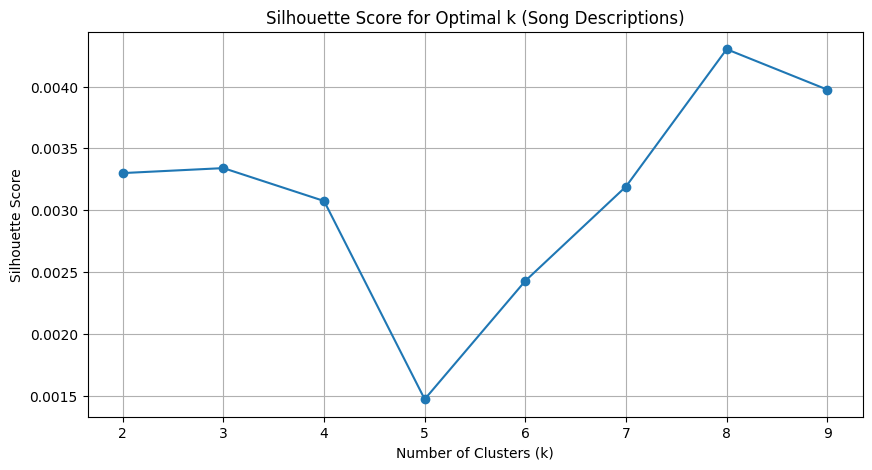

In [30]:
# Plotting Elbow Method (WCSS vs. Number of Clusters)
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k (Song Descriptions)')
plt.xticks(np.arange(2, 10))
plt.grid(True)
plt.show()

# Plotting Silhouette Score vs. Number of Clusters
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k (Song Descriptions)')
plt.xticks(np.arange(2, 10))
plt.grid(True)
plt.show()

after evauating the result of silhoueette and elbow method 

the value of k is 7 , as it is the optimal cluster for our data


In [31]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KUSHAL\AppData\Local\Temp\ipykernel_10864\1069843014.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


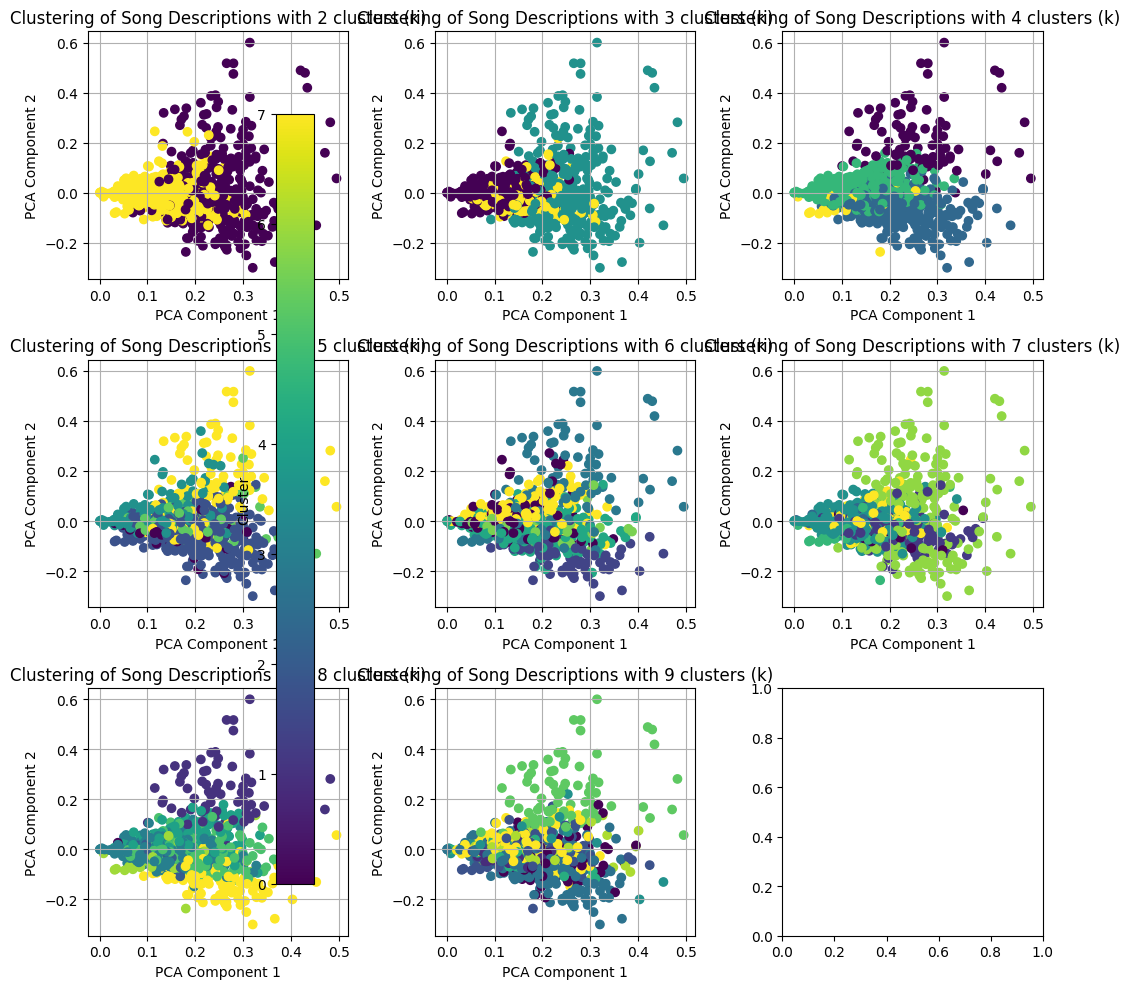

In [32]:
# Perform dimensionality reduction for visualization using PCA
svd = TruncatedSVD(n_components=2, random_state=0)
tfidf_svd = svd.fit_transform(matrix)
fig,axs=plt.subplots(3,3)
fig.set_size_inches(10, 10)
scatter_plots=[]
# Initialize MiniBatchKMeans clustering with optimal k (e.g., based on elbow method or silhouette score)
for i in range(2,10):
    k = i  # Example: Optimal number of clusters
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
    kmeans.fit(matrix)

    # Get cluster labels and plot clusters in a scatter plot
    cluster_labels = kmeans.labels_
    scatter_plot = axs[int((i-2)/3),(i-2)%3].scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], c=cluster_labels, cmap='viridis')
    # plt.scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], c=cluster_labels, cmap='viridis')
   
    axs[int((i - 2) / 3), (i - 2) % 3].set_xlabel('PCA Component 1')
    axs[int((i - 2) / 3), (i - 2) % 3].set_ylabel('PCA Component 2')
    axs[int((i - 2) / 3), (i - 2) % 3].set_title(f'Clustering of Song Descriptions with {i} clusters (k)')
    axs[int((i - 2) / 3), (i - 2) % 3].grid(True)

    scatter_plots.append(scatter_plot)  # Add scatter plot object to the list
   
plt.colorbar(scatter_plots[-2], ax=axs,location='left',pad=0.05, label='Cluster')
plt.tight_layout()
plt.show()

In [33]:
tfidf_svd

array([[ 0.24963526, -0.11549301],
       [ 0.15750673, -0.01755026],
       [ 0.10924705, -0.03422989],
       ...,
       [ 0.11434478, -0.04806758],
       [ 0.0583289 , -0.01091822],
       [ 0.22606498, -0.04341056]])

In [34]:
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.sparse import csr_matrix

# # Assuming 'matrix' is a sparse matrix in CSR format
# sparse_matrix = csr_matrix(matrix)

# # Compute cosine similarity using sparse matrices
similar = cosine_similarity(matrix)

In [35]:
similar[0]

array([1.00000000e+00, 4.16674100e-02, 3.08614149e-02, 1.47171148e-01,
       1.81173354e-02, 2.11980722e-02, 0.00000000e+00, 8.51896605e-02,
       7.32379846e-02, 3.31575351e-02, 1.75082520e-02, 3.30838260e-02,
       2.17918945e-02, 2.72326861e-02, 2.86800651e-02, 4.68273750e-02,
       2.18425354e-02, 7.42514523e-02, 7.17984437e-02, 1.44273130e-02,
       1.34786430e-02, 3.27414634e-02, 1.65287716e-02, 4.40734684e-02,
       4.39808893e-02, 3.15666239e-02, 1.53964596e-02, 0.00000000e+00,
       6.37268541e-02, 3.64102356e-02, 7.28397072e-02, 0.00000000e+00,
       2.49031394e-02, 4.54421527e-02, 1.60109972e-02, 5.16012273e-02,
       3.02877396e-02, 2.62717389e-02, 2.93141710e-02, 2.30582051e-02,
       3.34593204e-02, 4.02122514e-02, 1.24914426e-02, 5.51870812e-02,
       3.07627993e-02, 8.23091671e-03, 1.17246117e-01, 6.32241864e-02,
       2.75393769e-01, 3.33777990e-02, 2.37634997e-02, 2.83246073e-02,
       2.42508593e-02, 2.57070459e-02, 3.52339993e-02, 1.52555825e-01,
      

In [36]:
df['song']

0                   be who you are
1                 a million to one
2                perfect strangers
3        murders in the rue morgue
4                can't happen here
                   ...            
19995             the trolley song
19996     don't forget to remember
19997                 tender heart
19998    jesus don't give up on me
19999                 damaged soul
Name: song, Length: 20000, dtype: object

In [37]:
# df[df['song']=="city's burning"].index[0]

Now we are making recommder function for getting the songs


In [38]:
def recommder(song_name):
    idx=df[df['song']==song_name].index[0]
    distance=sorted(list(enumerate(similar[idx])), key=lambda x: x[1], reverse=True)
    song=[]
    for s_id in distance[1:20]:
        song.append(df.iloc[s_id[0]].song)
    return song
    
    

In [39]:
# recommder("steel drivin' man")

In [40]:
print(pp.iloc[0].text)

be who you are  
don't ever change  
the world was made to measure for your smile  
so smile.  
  
those crazy dreams  
we threw, we threw away  
i never been alone with you  
i never could  
they say  
  
that love will find a way  
and love will never be set free  
i won't ever let you see  
you could not understand  
you never will  
  
be who you are  
i bless i bless your name  
and all that summer madness caused the rain  
and we, we  
  
the glory that we made  
my love will grace the halls of time  
a love that never can be mine  
you could not love me then  
i love you still  
  
be who you are  
seize life and find a way  
and i will be that shadow loving who you are  
be who you are  
we were




Now we are gonna do the dumping of our code to bytes through pickle with dump method

In [41]:
def artist_songs(song_name):
    index_range=pp[pp['song']==song_name].artist
    artist_list=pp[pp['artist']==index_range.iloc[0]].song
    return artist_list

In [42]:
pde=artist_songs('Tuna').tolist()

In [43]:
pde

['Antarctica',
 'Plus Profond',
 'You Hurt Me',
 '2 Wicky',
 'My Child',
 "L'odeur Animale",
 'Shampoo',
 'Pink Fluffy Dinosaurs',
 'Heartbeat',
 'Battersea',
 'Sometimes',
 'The Night Before',
 'Tuna',
 'Blue Wonder Power Milk',
 'Club Montepulciano',
 'Neon',
 'Music Box',
 'Someone',
 'Sarangi',
 'Mad About You',
 'Out Of Sight']

In [44]:
import pickle

In [60]:
# pickle.dump(similar, open('similar.pkl', 'wb'))

In [66]:
# pickle.dump(df, open('df.pkl', 'wb'))

In [47]:
# Dictionary for genre values (with values converted to strings)
genre_values = {
    'Classical': 'Orchestral, Symphonic, Compositional complexity, Instrumental mastery, Elegance, '
                 'Formal structure, Timelessness, Emotionally evocative, Virtuosity',
    'Heavy Metal': 'Aggression, Distortion, Amplification, Dark themes, Intensity, Rebellion, '
                   'Complex guitar riffs, Screaming vocals, Power',
    'Punk': 'Anarchy, Rebellion, DIY ethos, Raw energy, Fast tempo, Anti-establishment, '
            'Political dissent, Social commentary, Minimalism',
    'Reggaeton': 'Rhythm, Danceability, Spanish lyrics, Latin beats, Urban culture, Sensuality, '
                 'Party atmosphere, Caribbean influence, Fusion of genres',
    'Indie': 'Alternative, DIY spirit, Non-conformity, Quirkiness, Artistic expression, Subculture, '
             'Introspection, Authenticity, Underground',
    'Gospel': 'Faith, Spirituality, Worship, Soulful vocals, Joy, Testimony, Redemption, Church, '
              'Hope',
    'Metalcore': 'Aggression, Breakdowns, Screamed vocals, Melodic elements, Technical proficiency, '
                 'Emotional intensity, Dual vocal styles, Heavy guitar riffing, Catharsis',
    'Ska': 'Upbeat tempo, Offbeat rhythm, Horn sections, Jamaican influence, Danceable grooves, Fun, '
           'Lightheartedness, Subcultural identity, Skanking',
    'Funk': 'Groove, Rhythmic syncopation, Soulful vocals, Danceability, Improvisation, '
            'Tight instrumentation, Syncopated basslines, Horn sections, Party atmosphere',
    'Disco': 'Dancefloor, Glittering, Funky basslines, Four-on-the-floor beat, Studio production, '
             'High energy, Glamour, Nightlife, Liberation'
}


# Dictionary for genre labels
genre_labels = {
    'Classical': 0,
    'Heavy Metal': 1,
    'Punk': 2,
    'Reggaeton': 3,
    'Indie': 4,
    'Gospel': 5,
    'Metalcore': 6,
    'Ska': 7,
    'Funk': 8,
    'Disco': 9
}


In [65]:
df

,artist,song,cleaned text,genre
0,Bee Gees,be who you are,Be Do n't ever change The world made measure s...,Disco
1,Helloween,a million to one,Born somewhere unseen unknown Just like worder...,Gospel
2,Neil Sedaka,perfect strangers,An afternoon sad affair Shared hope mending br...,Gospel
3,Iron Maiden,murders in the rue morgue,I remember plain day Although happened dark ni...,Heavy Metal
4,Rainbow,can't happen here,Contaminated fish micro chip Huge supertanker ...,Disco
...,...,...,...,...
19995,Judy Garland,the trolley song,With high starched-collar high-topped shoe And...,Disco
19996,Bee Gees,don't forget to remember,Oh heart wo n't believe left I keep telling se...,Disco
19997,Lionel Richie,tender heart,Every night every day heart feel pain I wake t...,Classical
19998,Hank Williams Jr.,jesus don't give up on me,Jesus I know I 've neglected little thing big ...,Gospel


In [48]:
Xgenre_values=list(genre_values.values())
Ygenre_values=list(genre_values.keys())


In [49]:
tfidf_vectorizer = TfidfVectorizer()
Xgenre_values


['Orchestral, Symphonic, Compositional complexity, Instrumental mastery, Elegance, Formal structure, Timelessness, Emotionally evocative, Virtuosity',
 'Aggression, Distortion, Amplification, Dark themes, Intensity, Rebellion, Complex guitar riffs, Screaming vocals, Power',
 'Anarchy, Rebellion, DIY ethos, Raw energy, Fast tempo, Anti-establishment, Political dissent, Social commentary, Minimalism',
 'Rhythm, Danceability, Spanish lyrics, Latin beats, Urban culture, Sensuality, Party atmosphere, Caribbean influence, Fusion of genres',
 'Alternative, DIY spirit, Non-conformity, Quirkiness, Artistic expression, Subculture, Introspection, Authenticity, Underground',
 'Faith, Spirituality, Worship, Soulful vocals, Joy, Testimony, Redemption, Church, Hope',
 'Aggression, Breakdowns, Screamed vocals, Melodic elements, Technical proficiency, Emotional intensity, Dual vocal styles, Heavy guitar riffing, Catharsis',
 'Upbeat tempo, Offbeat rhythm, Horn sections, Jamaican influence, Danceable gr

In [50]:
X_genre_features = tfidf_vectorizer.fit_transform(Xgenre_values)
print(X_genre_features)

  (0, 119)	0.2773500981126146
  (0, 36)	0.2773500981126146
  (0, 32)	0.2773500981126146
  (0, 115)	0.2773500981126146
  (0, 101)	0.2773500981126146
  (0, 41)	0.2773500981126146
  (0, 29)	0.2773500981126146
  (0, 69)	0.2773500981126146
  (0, 59)	0.2773500981126146
  (0, 17)	0.2773500981126146
  (0, 18)	0.2773500981126146
  (0, 106)	0.2773500981126146
  (0, 77)	0.2773500981126146
  (1, 80)	0.2971162154206395
  (1, 121)	0.19646180133280128
  (1, 92)	0.2971162154206395
  (1, 90)	0.2971162154206395
  (1, 51)	0.25257592763860126
  (1, 16)	0.2971162154206395
  (1, 85)	0.25257592763860126
  (1, 61)	0.25257592763860126
  (1, 113)	0.2971162154206395
  (1, 24)	0.2971162154206395
  (1, 2)	0.2971162154206395
  (1, 26)	0.2971162154206395
  :	:
  (8, 88)	0.28289012000084046
  (8, 49)	0.28289012000084046
  (8, 93)	0.24048244683600017
  (8, 55)	0.24048244683600017
  (8, 97)	0.24048244683600017
  (8, 6)	0.24048244683600017
  (8, 78)	0.24048244683600017
  (8, 21)	0.24048244683600017
  (8, 121)	0.18705509

In [51]:
classifier = LogisticRegression()
classifier.fit(X_genre_features, Ygenre_values)

LogisticRegression()

In [52]:
X_cluster_features = tfidf_vectorizer.transform(df['cleaned text'])
print(X_cluster_features)

  (0, 112)	1.0
  (1, 54)	1.0
  (2, 112)	0.7071067811865475
  (2, 54)	0.7071067811865475
  (3, 74)	0.7071067811865475
  (3, 24)	0.7071067811865475
  (4, 112)	1.0
  (5, 53)	1.0
  (6, 112)	0.11605177063713189
  (6, 76)	0.46420708254852755
  (6, 53)	0.8703882797784892
  (6, 38)	0.11605177063713189
  (7, 112)	0.7071067811865475
  (7, 39)	0.7071067811865475
  (9, 64)	0.7071067811865475
  (9, 54)	0.7071067811865475
  (10, 110)	1.0
  (11, 114)	0.04152273992686998
  (11, 112)	0.04152273992686998
  (11, 44)	0.9965457582448796
  (11, 39)	0.04152273992686998
  (11, 9)	0.04152273992686998
  (14, 112)	0.8944271909999159
  (14, 54)	0.4472135954999579
  (16, 112)	1.0
  :	:
  (19982, 53)	0.4472135954999579
  (19983, 112)	0.7276068751089989
  (19983, 76)	0.48507125007266594
  (19983, 74)	0.48507125007266594
  (19984, 112)	1.0
  (19985, 53)	1.0
  (19986, 112)	0.9486832980505138
  (19986, 43)	0.31622776601683794
  (19987, 114)	1.0
  (19988, 112)	0.9486832980505138
  (19988, 42)	0.31622776601683794
  (1998

In [53]:
prdectitors = classifier.predict(X_cluster_features)    


In [64]:
df['genre'] = prdectitors

In [55]:
predicted_cluster_genres = [genre_labels[label] for label in prdectitors]

In [63]:
# df['genre'] = predicted_cluster_genres   
# del df['text'], df['genre'] 

In [57]:
df['genre'].value_counts()

genre
9    8325
0    6722
5    1712
1    1064
3     604
2     450
7     361
8     317
4     295
6     150
Name: count, dtype: int64

In [58]:
from sklearn.cluster import KMeans

In [59]:
X_combined = np.hstack((np.array(Xgenre_values), np.array(X_cluster_features)))

# Step 5: K-Means Clustering
k = 7  # Number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_combined)



ValueError: could not convert string to float: 'Orchestral, Symphonic, Compositional complexity, Instrumental mastery, Elegance, Formal structure, Timelessness, Emotionally evocative, Virtuosity'

In [ ]:
print(X_cluster_features)

  (0, 53)	1.0
  (1, 87)	0.7868856246952748
  (1, 49)	0.308549434308316
  (1, 44)	0.308549434308316
  (1, 40)	0.308549434308316
  (1, 9)	0.308549434308316
  (2, 40)	1.0
  (3, 112)	1.0
  (4, 9)	1.0
  (5, 38)	1.0
  (7, 68)	1.0
  (9, 43)	0.7071067811865475
  (9, 40)	0.7071067811865475
  (10, 64)	0.31622776601683794
  (10, 53)	0.9486832980505138
  (12, 49)	1.0
  (15, 112)	0.8944271909999159
  (15, 53)	0.4472135954999579
  (16, 112)	1.0
  (17, 53)	1.0
  (18, 112)	0.8944271909999159
  (18, 76)	0.4472135954999579
  (19, 53)	1.0
  (22, 114)	0.7071067811865476
  (22, 112)	0.7071067811865476
  :	:
  (19979, 112)	0.7071067811865475
  (19979, 64)	0.7071067811865475
  (19982, 112)	0.3333333333333333
  (19982, 76)	0.3333333333333333
  (19982, 74)	0.3333333333333333
  (19982, 53)	0.6666666666666666
  (19982, 52)	0.3333333333333333
  (19982, 39)	0.3333333333333333
  (19983, 80)	0.9701425001453319
  (19983, 43)	0.24253562503633297
  (19984, 112)	1.0
  (19985, 112)	1.0
  (19986, 74)	0.9922778767136676
  